In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV


Imports all necessary libraries for data handling, visualization, modeling, and evaluation.

In [2]:
df = pd.read_csv("football_match_data.csv")

# Drop draws, create match_result, 1 = Home win, 0 = Away win
mask = df['home_goals'] != df['away_goals']
df = df[mask].copy()
df['match_result'] = (df['home_goals'] > df['away_goals']).astype(int)
df.dropna(inplace=True)
print(df.head())

         date      time                  league     season  \
0  2014-08-16  12:45:00  english_premier_league  2014-2015   
2  2014-08-16  15:00:00  english_premier_league  2014-2015   
3  2014-08-16  15:00:00  english_premier_league  2014-2015   
5  2014-08-16  15:00:00  english_premier_league  2014-2015   
6  2014-08-16  17:30:00  english_premier_league  2014-2015   

             home_team       away_team  home_goals  away_goals   home_xG  \
0    Manchester United         Swansea         1.0         2.0  1.166350   
2  Queens Park Rangers            Hull         0.0         1.0  1.900670   
3                Stoke     Aston Villa         0.0         1.0  0.423368   
5             West Ham       Tottenham         0.0         1.0  1.853100   
6              Arsenal  Crystal Palace         2.0         1.0  1.554110   

    away_xG  match_result  
0  0.278076             0  
2  1.117570             0  
3  0.909774             0  
5  1.017060             0  
6  0.158151             1  


Reads the football dataset CSV into a pandas DataFrame for further processing.

In [3]:
def add_time_of_day(df):
    df['time'] = pd.to_datetime(df['time'], format='%H:%M:%S').dt.time
    df['time_of_day'] = df['time'].apply(
        lambda x: 'day' if x < pd.to_datetime('17:00', format='%H:%M').time() else 
        ('evening' if x < pd.to_datetime('19:59', format='%H:%M').time() else 'night')
    )
    return df

Adds a new feature categorizing match start times into 'day', 'evening', or 'night' for time-based pattern recognition.

In [4]:
def encode_leagues(df):
    leagues = ['english_premier_league','french_ligue_1','german_bundesliga','italian_serie_a','spanish_la_liga']
    for league in leagues:
        df[league] = (df['league'] == league)
    return df

One-hot encodes the league column to allow models to differentiate between leagues.

In [5]:
def add_rolling_xG(df):
    df = df.sort_values(by='date')
    df['home_xG_rolling_20'] = df.groupby('home_team')['home_xG'].transform(lambda x: x.shift().rolling(20, min_periods=1).mean())
    df['away_xG_rolling_20'] = df.groupby('away_team')['away_xG'].transform(lambda x: x.shift().rolling(20, min_periods=1).mean())
    return df


Calculates 20-match rolling averages for home and away teams' xG to capture long-term form trends.

In [6]:
df = add_time_of_day(df)
df = encode_leagues(df)
df = add_rolling_xG(df)

In [7]:
df[['date', 'home_team', 'away_team', 'season']].sort_values(by=['date', 'home_team', 'away_team']).duplicated(subset=['date', 'home_team', 'away_team'], keep=False).value_counts()


False    12246
True      2578
Name: count, dtype: int64

Noticed some duplicates in the dataset

In [8]:
df = df.drop_duplicates(subset=['date', 'home_team', 'away_team', 'home_goals', 'away_goals', 'home_xG', 'away_xG'], keep='first')

Remove these duplicates

In [9]:
df[['date', 'home_team', 'away_team', 'season']].sort_values(by=['date', 'home_team', 'away_team']).duplicated(subset=['date', 'home_team', 'away_team'], keep=False).value_counts()


False    13535
Name: count, dtype: int64

Verify that they have been removed

In [10]:
home_dummies = pd.get_dummies(df['home_team'], prefix='home')
away_dummies = pd.get_dummies(df['away_team'], prefix='away')
df = pd.concat([df, home_dummies, away_dummies], axis=1)


Create one-hot encoded columns for home and away teams, and add them to the main dataframe for model readiness.

In [11]:
df.drop(columns=['date', 'time', 'league', 'season', 'home_team', 'away_team', 'home_goals', 'away_goals', 'home_xG', 'away_xG'], inplace=True)

Drop columns not needed for modeling

In [12]:
df.replace({True: 1, False: 0}, inplace=True)
df = pd.concat([df, pd.get_dummies(df['time_of_day'], prefix='time')], axis=1)
df.drop(columns=['time_of_day'], inplace=True)
df.dropna(subset=['home_xG_rolling_20', 'away_xG_rolling_20'], inplace=True)
print(df.head())
print({len(df)})
print("Number of rows:", len(df))
print("Number of rows:", df.shape[0])
print("Antall kolonner:", df.shape[1])


C:\Users\99jon\AppData\Local\Temp\ipykernel_24180\797838823.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({True: 1, False: 0}, inplace=True)


      match_result  english_premier_league  french_ligue_1  german_bundesliga  \
1469             0                       0               1                  0   
1473             0                       0               1                  0   
1475             0                       0               1                  0   
1479             1                       0               1                  0   
1478             1                       0               1                  0   

      italian_serie_a  spanish_la_liga  home_xG_rolling_20  \
1469                0                0            2.214810   
1473                0                0            2.064000   
1475                0                0            1.025000   
1479                0                0            1.439560   
1478                0                0            1.806705   

      away_xG_rolling_20  home_AC Milan  home_Ajaccio  ...  away_Villarreal  \
1469            0.750184              0             0  ...   

Converts all boolean columns to integers, one-hot encodes time-of-day categories, and removes rows where rolling xG values are NaN.

In [13]:
team_name = "Liverpool"  # Change this to any team in your dataset

# Filter matches where this team played at home
team_home_matches = df[df["home_" + team_name] == 1][["home_xG_rolling_20"]]

# Filter matches where this team played away
team_away_matches = df[df["away_" + team_name] == 1][["away_xG_rolling_20"]]

# Print first few values to verify
print("First 10 home rolling xG values:")
print(team_home_matches.head(10))

print("\nFirst 10 away rolling xG values:")
print(team_away_matches.head(10))


First 10 home rolling xG values:
     home_xG_rolling_20
37             1.331920
62             1.030009
100            1.207216
123            1.038388
189            1.172760
221            1.523397
243            1.631773
266            1.773357
277            1.661764
296            1.626040

First 10 away rolling xG values:
     away_xG_rolling_20
28             0.901889
45             1.822530
77             1.341136
90             1.385385
117            1.160098
131            1.125575
157            1.150664
171            1.240724
200            1.221430
210            1.315538


Apply a check to see if rolling xG works properly

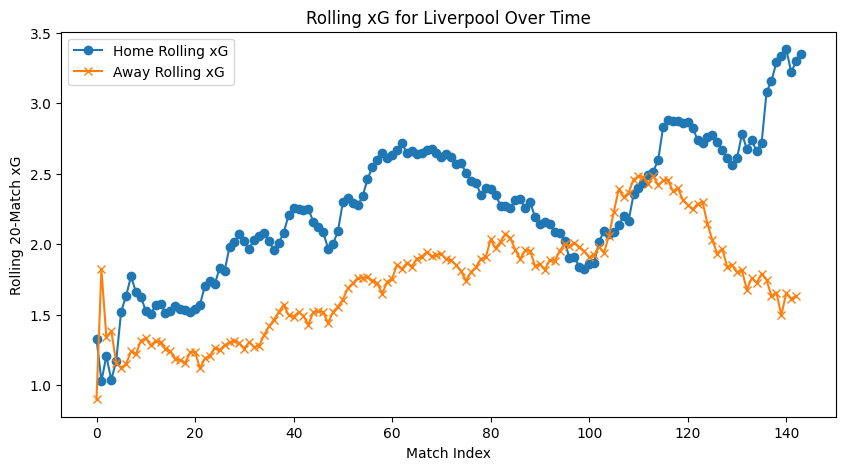

In [14]:
# Plot home and away rolling xG over match index
plt.figure(figsize=(10,5))
plt.plot(team_home_matches.reset_index(drop=True), label="Home Rolling xG", marker="o")
plt.plot(team_away_matches.reset_index(drop=True), label="Away Rolling xG", marker="x")
plt.xlabel("Match Index")
plt.ylabel("Rolling 20-Match xG")
plt.title(f"Rolling xG for {team_name} Over Time")
plt.legend()
plt.show()


Visualize it

In [15]:
X = df.drop(columns=['match_result'])
y = df['match_result']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Splits the data into training and testing sets with an 80-20 ratio for model evaluation.

In [16]:

param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid = GridSearchCV(
    estimator=XGBClassifier(eval_metric='logloss', random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train.astype(float), y_train)

print("Best parameters:", grid.best_params_)
print("Best accuracy:", grid.best_score_)

# Use best trained model
xgb_model = grid.best_estimator_



Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Best accuracy: 0.6852949477843636


Trains the model on the training dataset with hyperparam-tuning.

In [17]:
preds = xgb_model.predict(X_test.astype(float))
print(f"Accuracy: {accuracy_score(y_test, preds):.4f}")
print(classification_report(y_test, preds))

Accuracy: 0.6798
              precision    recall  f1-score   support

           0       0.62      0.50      0.55      1054
           1       0.71      0.80      0.75      1604

    accuracy                           0.68      2658
   macro avg       0.66      0.65      0.65      2658
weighted avg       0.67      0.68      0.67      2658



Makes predictions on the test set and displays classification accuracy and metrics.

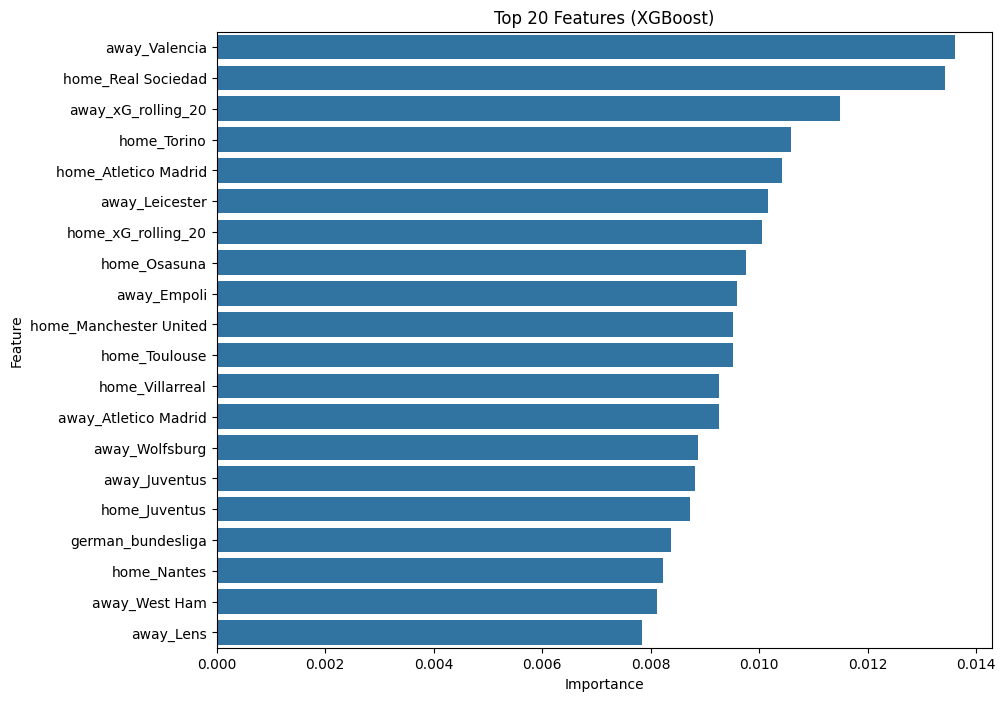

In [18]:
importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=importances.head(20), x='Importance', y='Feature')
plt.title('Top 20 Features (XGBoost)')
plt.show()

Visualizes the most influential features based on model gain scores.

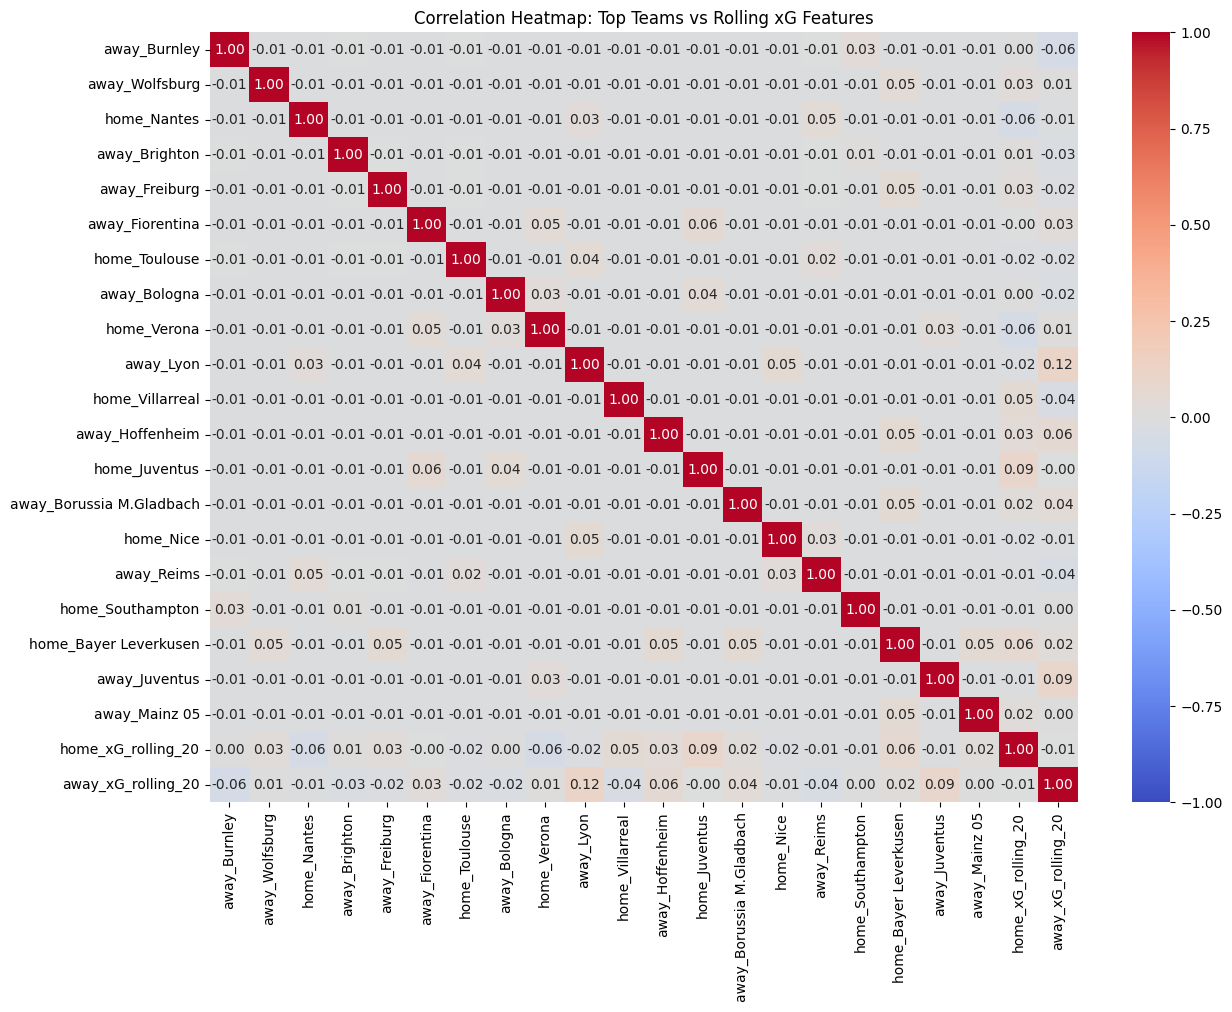

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define top team features based on model importance
top_features = [
    'away_Burnley', 'away_Wolfsburg', 'home_Nantes', 'away_Brighton', 'away_Freiburg',
    'away_Fiorentina', 'home_Toulouse', 'away_Bologna', 'home_Verona', 'away_Lyon',
    'home_Villarreal', 'away_Hoffenheim', 'home_Juventus', 'away_Borussia M.Gladbach',
    'home_Nice', 'away_Reims', 'home_Southampton', 'home_Bayer Leverkusen',
    'away_Juventus', 'away_Mainz 05'
]

# Add rolling xG columns
features_to_check = top_features + ['home_xG_rolling_20', 'away_xG_rolling_20']

# Compute correlation matrix
corr_matrix = df[features_to_check].corr()

# Plot the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap: Top Teams vs Rolling xG Features")
plt.show()

<Figure size 1000x2000 with 0 Axes>

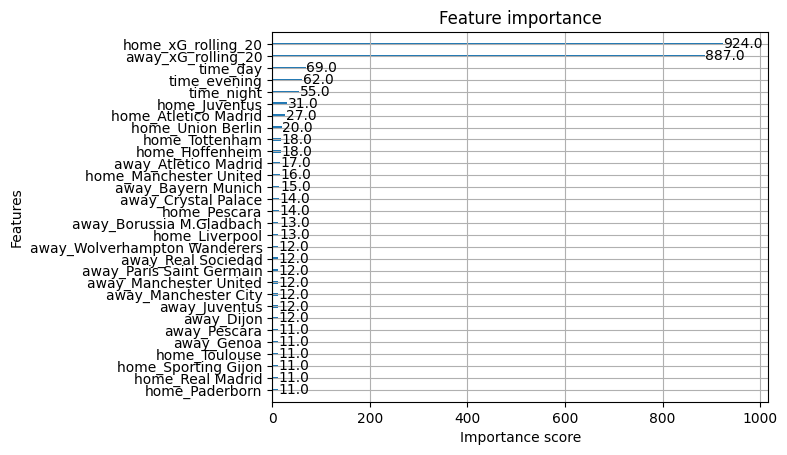

In [20]:
from xgboost import plot_importance
plt.figure(figsize=(10, 20))
plot_importance(xgb_model, max_num_features=30)
plt.show()

Displays feature importance based on how often each feature was used in the model.

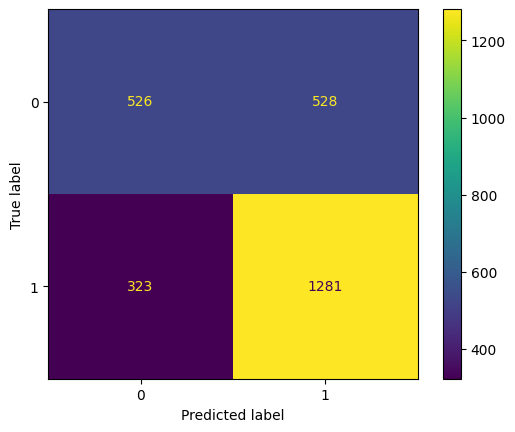

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = xgb_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()


Visualizes true positives, false positives, false negatives, and true negatives of model predictions.

In [22]:
import random

sample_indices = random.sample(list(X_test.index), 10)
sample_data = X_test.loc[sample_indices]
sample_preds = xgb_model.predict(sample_data.astype(float))

for idx, pred in zip(sample_indices, sample_preds):
    actual = y_test.loc[idx]
    row = df.loc[idx]
    print(f"Match {idx} — Predicted: {pred}, Actual: {actual}")
    print(f"  home_xG_rolling_20: {row['home_xG_rolling_20']}, away_xG_rolling_20: {row['away_xG_rolling_20']}")
    print(f"  Home team: {[col for col in row.index if col.startswith('home_') and row[col]==1]}")
    print(f"  Away team: {[col for col in row.index if col.startswith('away_') and row[col]==1]}")
    print("------")


Match 914 — Predicted: 1, Actual: 1
  home_xG_rolling_20: 0.9301365, away_xG_rolling_20: 1.0508184
  Home team: ['home_Mainz 05']
  Away team: ['away_Paderborn']
------
Match 9585 — Predicted: 1, Actual: 1
  home_xG_rolling_20: 1.0780106666666667, away_xG_rolling_20: 1.0270457
  Home team: ['home_Mallorca']
  Away team: ['away_Espanyol']
------
Match 9122 — Predicted: 0, Actual: 0
  home_xG_rolling_20: 0.9726997300000001, away_xG_rolling_20: 0.99121515
  Home team: ['home_Caen']
  Away team: ['away_Bordeaux']
------
Match 8503 — Predicted: 1, Actual: 1
  home_xG_rolling_20: 1.7189653, away_xG_rolling_20: 0.7793694166666666
  Home team: ['home_AC Milan']
  Away team: ['away_Parma Calcio 1913']
------
Match 4266 — Predicted: 0, Actual: 0
  home_xG_rolling_20: 1.7735103000000003, away_xG_rolling_20: 2.8204059999999997
  Home team: ['home_Atletico Madrid']
  Away team: ['away_Barcelona']
------
Match 8510 — Predicted: 1, Actual: 1
  home_xG_rolling_20: 1.9533620000000003, away_xG_rolling_2

Displays individual match predictions, actual results, and key features to manually inspect prediction correctness.

ROC AUC Score: 0.7261


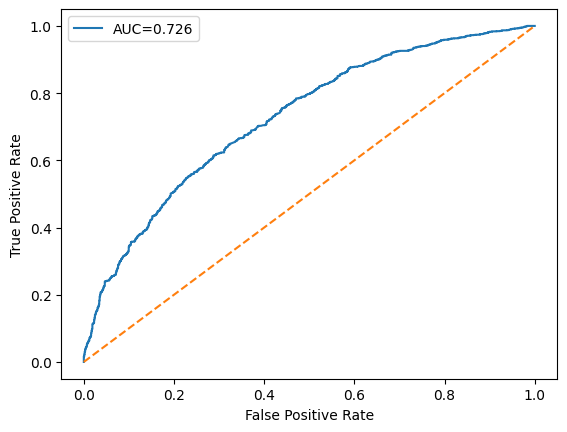

In [23]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

probs = xgb_model.predict_proba(X_test)[:,1]
auc_score = roc_auc_score(y_test, probs)
print(f"ROC AUC Score: {auc_score:.4f}")

fpr, tpr, _ = roc_curve(y_test, probs)
plt.plot(fpr, tpr, label=f'AUC={auc_score:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


Plots the ROC curve and calculates the AUC score to measure model discrimination ability.